# Weather Generator (WG) Medina Basin: SPI and SPEI Calculations

This workbook calculates the 3-month Standardized Precipitation Index (SPI) and Standardized Precipitation Evapotranspiration Index (SPEI) for the Medina basin from 2031-2060 from the calibrated weather generator results. These probabilistic indices are then used on 1993-2022 observed values and compared to 1) SPEI and SPI calculated from 1981-2010 and 2) SPEI and SPI calculated from LOCA2 2031-2060.

These two 'standardized' indices are calculated by:

1. Fitting a probability distribution to the data set
2. Determining a probability value for each value in the data set
3. Transforming this probability to an equivalent ZScore from the standard normal distribution.
    * The ZScore value provides the index value

The SPI is calculated from monthly total precipitation. The monthly totals are aggregated to 3-, 6-, and 12-month rolling windows to create the data set value generates the SPI.
* Pearson Type III (or 3 parameter Gamma) distribution is used for SPI

The SPEI uses the total monthly deficit and aggregated monthly deficits using 3-, 6-, and 12-month rolling windows to create the data set values for the SPEI.
* Log-logistic distribution (3 parameter) is used for SPEI

The deficit ($D$) is:

\begin{equation*}
    D_{i} = P_{i} - PET_{i}
\end{equation*}

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from scipy import stats as sstats
from math import exp
import datetime as dt
import seaborn as sns
import pickle
from copy import deepcopy

In [3]:
BasKey = "Medina"

In [4]:
NumReal = 1000

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

In [6]:
IN_DIR1 = r'C:\Users\nmartin\Documents\EAA_Drought_Future_Weather\NumModels\Final\%s\Results\Simulated' % BasKey
IN_DIR2 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\LOCA2\SPEI'
IN_DIR3 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\Processed_Historical\SPEI'
OUT_DIR = r'C:\Users\nmartin\Documents\EAA_Drought_Future_Weather\NumModels\Final\%s\Results\Processed' % BasKey

In [7]:
ProjFileRoot = "%s_R%d_DF.pickle"
MonIndexer = [ x for x in range(1,13,1)]

In [8]:
# our standard normal or ZScore parameters
ZMu = 0.0
ZStd = 1.0

Lambdas

In [9]:
# lambdas
ConvCFStoM3D = lambda cfs: ( cfs * ( ( 24.0 * 60.0 * 60.0 ) / 1.0 ) ) * ( pow(1.0, 3.0) / pow( 3.280839895, 3.0 ) )
setYrMo = lambda yr, mo: ( int(yr) * 100 ) + int(mo)
calcYr = lambda indx: int( indx / 100 )
calcMo = lambda indx, yr: int( indx - ( yr * 100 ) )

## Load the LOCA2 Result which Include Historical results

These are the 1993-2021 cumulative values for each month and the historical SPEI or SPI and the LOCA2 SPEI or SPI

### SPEI

In [10]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, BasKey, "%s_SPEI.xlsx" % BasKey ) )

In [11]:
CD3moObsDF = pd.read_excel( InFiler, sheet_name="SPEI_3mo", header=0, index_col=0, parse_dates=True )

In [12]:
CD3moObsDF["Month"] = CD3moObsDF.index.month

In [13]:
CD3moObsDF = CD3moObsDF.loc[pd.Timestamp( 1993, 1, 1, 0):pd.Timestamp(2022, 12, 31, 23, 59, )].copy()

In [14]:
display( HTML( CD3moObsDF.head().to_html() ) )

,CumDef,CumProb (2031-2060),LOCA2 SPEI (2031-2060),CumProb (1981-2010),SPEI (1981-2010),Month
DateTime,,,,,,
1993-01-01,52.029755,0.958059,1.728594,0.827279,0.943469,1
1993-02-01,-8.485944,0.908424,1.331112,0.719425,0.581135,2
1993-03-01,-84.652512,0.832716,0.964952,0.540387,0.101409,3
1993-04-01,-156.795441,0.791352,0.811120,0.561713,0.155314,4
1993-05-01,-206.430984,0.741572,0.648199,0.521025,0.052725,5


In [15]:
display( HTML( CD3moObsDF.tail().to_html() ) )

,CumDef,CumProb (2031-2060),LOCA2 SPEI (2031-2060),CumProb (1981-2010),SPEI (1981-2010),Month
DateTime,,,,,,
2022-08-01,-416.057281,0.636828,0.349992,0.296536,-0.534391,8
2022-09-01,-341.811554,0.640024,0.358524,0.499621,-0.000950,9
2022-10-01,-220.628647,0.682716,0.475308,0.445521,-0.136987,10
2022-11-01,-215.009232,0.293525,-0.543115,0.146863,-1.049982,11
2022-12-01,-132.575348,0.487618,-0.031042,0.254115,-0.661598,12


### SPI

In [16]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, BasKey, "%s_SPI.xlsx" % BasKey ) )

In [17]:
CP3moObsDF = pd.read_excel( InFiler, sheet_name="SPI_3mo", header=0, index_col=0, parse_dates=True )

In [18]:
CP3moObsDF["Month"] = CP3moObsDF.index.month

In [19]:
CP3moObsDF = CP3moObsDF.loc[pd.Timestamp( 1993, 1, 1, 0):pd.Timestamp(2022, 12, 31, 23, 59, )].copy()

In [20]:
display( HTML( CP3moObsDF.head().to_html() ) ) 

,CumPre,CumProb (2031-2060),LOCA2 SPI (2031-2060),CumProb (1981-2010),SPI (1981-2010),Month
DateTime,,,,,,
1993-01-01,240.111481,0.944724,1.595717,0.808404,0.872029,1
1993-02-01,180.678650,0.862750,1.092759,0.755240,0.691072,2
1993-03-01,158.068207,0.735323,0.628993,0.543935,0.110352,3
1993-04-01,167.558548,0.661746,0.417233,0.513146,0.032958,4
1993-05-01,216.700363,0.617556,0.299067,0.525691,0.064442,5


In [21]:
display( HTML( CP3moObsDF.tail().to_html() ) )

,CumPre,CumProb (2031-2060),LOCA2 SPI (2031-2060),CumProb (1981-2010),SPI (1981-2010),Month
DateTime,,,,,,
2022-08-01,192.869141,0.647279,0.377985,0.475230,-0.062130,8
2022-09-01,206.512512,0.595513,0.241749,0.575677,0.190846,9
2022-10-01,228.533813,0.592355,0.233606,0.478654,-0.053532,10
2022-11-01,124.513641,0.208584,-0.811345,0.124690,-1.151856,11
2022-12-01,115.475227,0.365698,-0.343268,0.380356,-0.304545,12


## Load the Weather Generator Projected Future Data and Aggregate to 3-month Windows

Load all realizations to focused DataFrames of the needed quantities and store in a dictionary by realization.

In [22]:
ModPreDict = dict()
ModDefDict = dict()

In [23]:
for curReal in range(1, NumReal+1):
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (BasKey, curReal) ) )
    curDF = pd.read_pickle( InFiler, compression='zip' )
    curPre = curDF[["Precip_mm"]].copy()
    curDef = curDF[["Def_mm"]].copy()
    curMonPreDF = curPre.resample('MS').sum()
    curMonDefDF = curDef.resample('MS').sum()
    curMonPreDF["Year"] = curMonPreDF.index.year
    curMonPreDF["Month"] = curMonPreDF.index.month
    curMonDefDF["Year"] = curMonDefDF.index.year
    curMonDefDF["Month"] = curMonDefDF.index.month
    curMonPreDF["3moCum"] = curMonPreDF["Precip_mm"].rolling(window=3,).sum()
    curMonDefDF["3moCum"] = curMonDefDF["Def_mm"].rolling(window=3,).sum()
    curMonPreDF = curMonPreDF.loc[pd.Timestamp( 2031, 1, 1, 0):pd.Timestamp( 2060, 12, 31, 23, 59, )].copy()
    curMonDefDF = curMonDefDF.loc[pd.Timestamp( 2031, 1, 1, 0):pd.Timestamp( 2060, 12, 31, 23, 59, )].copy()
    ModPreDict[curReal] = curMonPreDF.copy()
    ModDefDict[curReal] = curMonDefDF.copy()
# end for

## Fit Distributions and Calculate Indices

### SPI: Pearson Type III

Fit Pearson Type III Distributions to each month and each window length.

Scipy stats fit for Pearson Type III returns a tuple with:

0. **skew**
1. **location**
2. **scale**

The cumulative distribution function (for Pearson Type III) is then used to estimate a cumulative probability for each moving sum value (i.e., each calendar month across all years in the data set). The cumulative probability is then transformed into a Z-Score using the standard normal distribution.

In [24]:
TotYears = ( 2060 - 2031 ) + 1
TotYears

30

In [25]:
TotEstYears = (2022 - 1993) + 1
TotEstYears

30

In [26]:
# create empty tracking dictionaries
M3MonDict = dict()
# loop through by integer month
for mI in MonIndexer:
    # get the observed first first
    obsDF = CP3moObsDF[CP3moObsDF["Month"] == mI].copy()
    extA3Mon = obsDF["CumPre"].to_numpy(dtype=np.float32)
    # next get a single array for the month from all models
    allMonPreList = list()
    for curReal in range(1,NumReal+1):
        curDF = ModPreDict[curReal]
        cMonDF = curDF[curDF["Month"] == mI].copy()
        allMonPreList.append( cMonDF["3moCum"].to_numpy(dtype=np.float32) )
    # end for
    a3Mon = np.concatenate( allMonPreList )
    # fit Pearson Type III distributions to these arrays
    fitT3Mon = sstats.pearson3.fit( a3Mon )
    lD3Mon = { "skew" : fitT3Mon[0], "location" : fitT3Mon[1],
               "scale" : fitT3Mon[2], }
    # now get the cumulative probability values from the distributions
    #   for the observed values.
    data3MCDF = sstats.pearson3.cdf( extA3Mon, lD3Mon["skew"], loc=lD3Mon["location"], 
                                     scale=lD3Mon["scale"] )
    SPI3Mo = sstats.norm.ppf( data3MCDF, loc=ZMu, scale=ZStd )
    # dictionary entries for this month
    M3MonDict[mI] = [ [data3MCDF, SPI3Mo, extA3Mon], lD3Mon ]
# end month for
# now rebuild to time series from the month tracking dictionary
spi3mList = list()
cprob3mList = list()
cumD3mList = list()
# loop through years and fill by month order
for yI in range(TotEstYears):
    for mI in MonIndexer:
        m3ArraySP = M3MonDict[mI][0][1]
        m3ArrayCP = M3MonDict[mI][0][0]
        m3ArrayCD = M3MonDict[mI][0][2]
        if yI < len( m3ArrayCP ):
            spi3mList.append( m3ArraySP[yI] )
            cprob3mList.append( m3ArrayCP[yI] )
            cumD3mList.append( m3ArrayCD[yI] )
        # end if
    # end inner for
# end outer for
# now build the time indexed DataFrame
DataDict = { "CumPre" : np.array( cumD3mList, dtype=np.float32 ),
             "WG CumProb (2031-2060)" : np.array( cprob3mList, dtype=np.float32 ),
             "WG SPI (2031-2060)" : np.array( spi3mList, dtype=np.float32 ),
             "LOCA2 CumProb (2031-2060)" : CP3moObsDF["CumProb (2031-2060)"].to_numpy(dtype=np.float32), 
             "LOCA2 SPI (2031-2060)" : CP3moObsDF["LOCA2 SPI (2031-2060)"].to_numpy(dtype=np.float32),
             "CumProb (1981-2010)" : CP3moObsDF["CumProb (1981-2010)"].to_numpy(dtype=np.float32), 
             "SPI (1981-2010)" : CP3moObsDF["SPI (1981-2010)"].to_numpy(dtype=np.float32), }
spi3DF = pd.DataFrame( index=CP3moObsDF.index, data=DataDict )
# now do the stats
stats3List = list()
indNList = list()
for mI in MonIndexer:
    lD3Mon = M3MonDict[mI][1]
    indNList.append( "skew_%d" % mI )
    indNList.append( "scale_%d" % mI )
    indNList.append( "loc_%d" % mI )
    stats3List.append( lD3Mon["skew"] )
    stats3List.append( lD3Mon["scale"] )
    stats3List.append( lD3Mon["location"] )
# end for
# build the DataFrame
stats3DF = pd.DataFrame( index=indNList, data={"SPI Fit Stats" : stats3List,} )

#### Output

In [27]:
display( HTML( spi3DF.head().to_html() ) )

,CumPre,WG CumProb (2031-2060),WG SPI (2031-2060),LOCA2 CumProb (2031-2060),LOCA2 SPI (2031-2060),CumProb (1981-2010),SPI (1981-2010)
DateTime,,,,,,,
1993-01-01,240.111481,0.851719,1.043833,0.944724,1.595717,0.808404,0.872029
1993-02-01,180.678650,0.671245,0.443355,0.862750,1.092759,0.755240,0.691072
1993-03-01,158.068207,0.392915,-0.271731,0.735323,0.628993,0.543935,0.110352
1993-04-01,167.558548,0.398523,-0.257171,0.661746,0.417233,0.513146,0.032958
1993-05-01,216.700363,0.470165,-0.074855,0.617556,0.299067,0.525691,0.064442


In [28]:
display( HTML( stats3DF.head().to_html() ) )

,SPI Fit Stats
skew_1,1.306151
scale_1,95.184620
loc_1,145.726790
skew_2,1.379863
scale_2,105.237530


Output to a spreadsheet

In [29]:
outXLSX = os.path.normpath( os.path.join( OUT_DIR, "%s_SPI.xlsx" % BasKey ) )
writer = pd.ExcelWriter( outXLSX )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00000'})
cLabel = "Stats_3mo"
stats3DF.to_excel( writer, sheet_name=cLabel, index_label="Stats" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 12 )
for column in stats3DF:
    column_width = max(stats3DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats3DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPI_3mo"
spi3DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spi3DF:
    column_width = max(spi3DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spi3DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
writer.close()

### SPEI: Log-Logistic

[Vicente-Serrano and others (2010)](https://journals.ametsoc.org/view/journals/clim/23/7/2009jcli2909.1.xml) developed the Standardized Precipitation Evapotranspiration Index (SPEI) to provide a climatic drought index that would be sensitive to global warming. The SPEI is congruent with the SPI; the primary difference is that monthly deficit (D) values are used in place of monthly precipitation (P) values. They also found that the log-logistic distribution (3 parameter) performed better than the Pearson Type III (or 3 parameter Gamma) distribution for calculating the SPEI from D values, which tend to be mostly negative in arid and semi-arid environments.

Unfortunately, the log-logistic distribution is not currently included in [SciPy stats](https://docs.scipy.org/doc/scipy/tutorial/stats.html) which is the package used for other distributions in this notebook (i.e., [Pearson Type III](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearson3.html) and [Normal](https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_norm.html) ).

In searching for a log-logistic implementation to use for the SPEI calculation, [Hosking and Wallis (1997) Regional Frequency Analysis](https://www.cambridge.org/core/books/regional-frequency-analysis/8C59835F9361705DAAE1ADFDEA7ECD30) provides a 'Generalized Logistic Distribution' in the Appendix with the information needed to estimate probability distribution values. The 'Generalized Logistic Distribution' is a reparameterized version of the log-logistic distribution of [Ahmad and others (1988)](https://www.sciencedirect.com/science/article/abs/pii/0022169488900157).

Two custom functions are presented below to calculate the probability distribution values using the 'Generalized Logistic Distribution' which provides a log-logistic distribution when the shape parameter (or $k$) is not equal to zero. After developing and testing these functions against the [lmoment3 package](https://open-hydrology.readthedocs.io/projects/lmoments3/en/stable/), the [Generalized Logistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genlogistic.html#scipy.stats.genlogistic) implementation in Scipy stats was discovered.

The custom function, L-moments approach is used going forward to calculate SPEI because:

1. lmoment3 package is not up to date with current versions of SciPy and will throw errors
2. SciPy Stats Genlogistic does not work with negative shape parameters and so cannot use the L-moment estimated distribution parameters. MLE-based parameter estimates seem close and reasonable but it is thought that the custom L-moments approach will be more stable in general.

In [30]:
def estimatellogparams( npArray ):
    """Estimate the parameters of a log-logistic distribution from an
    array of annual values.
    
    Estimate is done using L-moments and the "Generalized logistic distribution".
    This distribtion is a reparameterized version of the log-logistic
    distribution of Ahmad et al. (1988). Estimation is done using 
    the equations and procedure in Appendix A.7 of "Regional Frequency
    Analysis", Hosking and Wallis (1997)
    
    To estimate the distribution parameters (shape, scale, and location),
    the L-moments l1, l2, and t3 need to be calculated. These three
    L-moments can be estimated from the first three, sample weighted
    probability moments (b0, b1, and b2).
    
    Args:
        npArray (np.ndarray): Numpy, 1D array
    
    Returns:
        log-logistic parameters in dictionary, D:
            D["k"]: k or shape
            D["scale"]: alpha or scale
            D["loc"]: Eta or location
    """
    # imports
    import math
    # don't do any checking for type and assume that will always
    #  be Numpy ndarray for single argument
    totLen = len( npArray )
    # need a sorted array in increasing order
    srtAr = np.sort( npArray )
    # calculate sample probability weighted moments: b0, b1, b2
    b0 = srtAr.mean()
    b1 = 0.0
    for iI in range(2, totLen + 1):
        b1 += ( ( iI - 1 ) / ( totLen - 1 ) ) * srtAr[iI-1]
    # end for
    b1 = b1 / totLen
    b2 = 0.0
    for iI in range( 3, totLen + 1 ):
        b2 += ( ( ( iI - 1 ) * ( iI - 2 ) ) / ( ( totLen - 1 ) * (totLen - 2 ) ) ) * srtAr[iI-1]
    # end for
    b2 = b2 / totLen
    # calculate sample L-moments: l1, l2, t3
    l1 = b0
    l2 = (2.0 * b1 ) - b0
    l3 = ( 6.0 * b2 ) -  ( 6.0 * b1 ) + b0
    t3 = l3 / l2
    # estimate the distribution parameters
    shape = -1.0 * t3
    scale = ( l2 * math.sin( shape * math.pi ) ) / ( shape * math.pi )
    location = l1 - ( scale * ( ( 1.0 / shape ) - ( math.pi / math.sin( shape * math.pi ) ) ) )
    retDict = { "k" : shape,
                "scale" : scale,
                "loc" : location, }
    # return
    return retDict

In [31]:
def probDistLLogis( paramDict, npArray ):
    """Uses generalized logistic probability distribution to estimate cumulative
    probilities for each value in the Numpy array, npArray.
    
    Args:
        paramDict (dict): dictionary with best-fit parameter values for a 
                log-logisitic distribution. Must have keys: "k", "scale",
                "loc" which are the 3 required parameters
        npArray (np.ndarray): array from time series of monthly, rolling
                average values
    
    Returns:
        retArray (np.ndarray): cumulative probabilies for each npArray value
    """
    shape = paramDict["k"]
    location = paramDict["loc"]
    scale = paramDict["scale"]
    if shape == 0.0:
        # this is the special case of a logistic distribution with 2 params
        y = ( npArray - location ) / scale
    else:
        # this is the general case of the log-logistic distribution
        takeLogArray = 1.0 - ( shape * ( npArray - location ) / scale )
        useLogArray = np.where( takeLogArray <= 0.0, 1e-7, takeLogArray )
        y = ( -1.0 * ( 1.0 / shape ) ) * np.log( useLogArray )
    # end if
    retArray = 1.0 / ( 1.0 + np.exp( -1.0 * y  ) )
    # return
    return retArray

In [32]:
# create empty tracking dictionaries
M3MonDict = dict()
# loop through by integer month
for mI in MonIndexer:
    # get the observed first first
    obsDF = CD3moObsDF[CD3moObsDF["Month"] == mI].copy()
    extA3Mon = obsDF["CumDef"].to_numpy(dtype=np.float32)
    # next get a single array for the month from all models
    allMonDefList = list()
    for curReal in range(1, NumReal+1):
        curDF = ModDefDict[curReal]
        cMonDF = curDF[curDF["Month"] == mI].copy()
        allMonDefList.append( cMonDF["3moCum"].to_numpy(dtype=np.float32) )
    # end for
    a3Mon = np.concatenate( allMonDefList )
    # fit 'generalized logistic' distributions to these arrays
    lD3Mon = estimatellogparams( a3Mon )
    # now get the cumulative probability values from the distributions
    #   for the observed values.
    data3MCDF = probDistLLogis( lD3Mon, extA3Mon )
    # make sure the cumulative density is not less than 1.0 / (2* N years).
    data3MCDF = np.where( data3MCDF < (1.0/60.0), (1.0/60.0), data3MCDF )
    SPEI3Mo = sstats.norm.ppf( data3MCDF, loc=ZMu, scale=ZStd )
    # dictionary entries for this month
    M3MonDict[mI] = [ [data3MCDF, SPEI3Mo, extA3Mon], lD3Mon ]
# end month for
# now rebuild to time series from the month tracking dictionary
spei3mList = list()
cprob3mList = list()
cumD3mList = list()
# loop through years and fill by month order
for yI in range(TotEstYears):
    for mI in MonIndexer:
        m3ArraySP = M3MonDict[mI][0][1]
        m3ArrayCP = M3MonDict[mI][0][0]
        m3ArrayCD = M3MonDict[mI][0][2]
        if yI < len( m3ArrayCP ):
            spei3mList.append( m3ArraySP[yI] )
            cprob3mList.append( m3ArrayCP[yI] )
            cumD3mList.append( m3ArrayCD[yI] )
        # end if
    # end inner for
# end outer for
# now build the time indexed DataFrame
DataDict = { "CumDef" : np.array( cumD3mList, dtype=np.float32 ),
             "WG CumProb (2031-2060)" : np.array( cprob3mList, dtype=np.float32 ), 
             "WG SPEI (2031-2060)" : np.array( spei3mList, dtype=np.float32 ),
             "LOCA2 CumProb (2031-2060)" : CD3moObsDF["CumProb (2031-2060)"].to_numpy(dtype=np.float32), 
             "LOCA2 SPEI (2031-2060)" : CD3moObsDF["LOCA2 SPEI (2031-2060)"].to_numpy(dtype=np.float32),
             "CumProb (1981-2010)" : CD3moObsDF["CumProb (1981-2010)"].to_numpy(dtype=np.float32), 
             "SPEI (1981-2010)" : CD3moObsDF["SPEI (1981-2010)"].to_numpy(dtype=np.float32), }
spei3DF = pd.DataFrame( index=CD3moObsDF.index, data=DataDict )
# now do the stats
stats3List = list()
indNList = list()
for mI in MonIndexer:
    lD3Mon = M3MonDict[mI][1]
    indNList.append( "shape_%d" % mI )
    indNList.append( "scale_%d" % mI )
    indNList.append( "loc_%d" % mI )
    stats3List.append( lD3Mon["k"] )
    stats3List.append( lD3Mon["scale"] )
    stats3List.append( lD3Mon["loc"] )
# end for
# build the DataFrame
stats3DDF = pd.DataFrame( index=indNList, data={"SPEI Fit Stats" : stats3List,} )

In [33]:
display( HTML( spei3DF.head().to_html() ) )

,CumDef,WG CumProb (2031-2060),WG SPEI (2031-2060),LOCA2 CumProb (2031-2060),LOCA2 SPEI (2031-2060),CumProb (1981-2010),SPEI (1981-2010)
DateTime,,,,,,,
1993-01-01,52.029755,0.941986,1.571665,0.958059,1.728594,0.827279,0.943469
1993-02-01,-8.485944,0.885423,1.202539,0.908424,1.331112,0.719425,0.581135
1993-03-01,-84.652512,0.746902,0.664773,0.832716,0.964952,0.540387,0.101409
1993-04-01,-156.795441,0.851706,1.043776,0.791352,0.811120,0.561713,0.155314
1993-05-01,-206.430984,0.902418,1.295454,0.741572,0.648199,0.521025,0.052725


In [34]:
display( HTML( stats3DDF.head().to_html() ) )

,SPEI Fit Stats
shape_1,-0.372261
scale_1,43.855666
loc_1,-162.671120
shape_2,-0.340632
scale_2,50.117707


Output to a spreadsheet for later analysis

In [35]:
outXLSX = os.path.normpath( os.path.join( OUT_DIR, "%s_SPEI.xlsx" % BasKey ) )
writer = pd.ExcelWriter( outXLSX )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00000'})
cLabel = "Stats_3mo"
stats3DDF.to_excel( writer, sheet_name=cLabel, index_label="Stats" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 12 )
for column in stats3DDF:
    column_width = max(stats3DDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = stats3DDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "SPEI_3mo"
spei3DF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in spei3DF:
    column_width = max(spei3DF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = spei3DF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
writer.close()

## Plots

Want to do two different types of plots for graphically understanding what is going on

1. Heatmap of SPI by aggregation interval
2. Combined SPI columns with monthly discharge time series

### Heatmaps

In [36]:
display( HTML( spi3DF.describe().to_html() ) )

,CumPre,WG CumProb (2031-2060),WG SPI (2031-2060),LOCA2 CumProb (2031-2060),LOCA2 SPI (2031-2060),CumProb (1981-2010),SPI (1981-2010)
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,211.507645,0.442177,-0.198139,0.565655,0.257985,0.484175,-0.081240
std,140.944260,0.339045,1.632254,0.304176,1.133990,0.290488,1.032753
min,12.412292,0.000006,-4.383334,0.002352,-2.826697,0.016667,-2.128045
25%,113.007130,0.114796,-1.201412,0.313393,-0.486259,0.245029,-0.690231
50%,181.721283,0.409970,-0.227622,0.606764,0.270896,0.496388,-0.009054
75%,266.484482,0.741534,0.648084,0.831222,0.959006,0.740114,0.643696
max,743.269165,1.000000,5.369743,0.998782,3.031061,0.996387,2.686231


In [37]:
pMax = 3.0
pMin = -3.0

In [38]:
cColors = [ "darkred", "firebrick", "indianred", "lightcoral", "lightsalmon", "antiquewhite",
            "antiquewhite", "antiquewhite", "lightblue", "cadetblue", "royalblue", "mediumblue", "midnightblue" ]
# -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0
cNodes = [0.0, 0.0833, 0.1666, 0.25, 0.3333, 0.4166, 0.50, 0.5833, 0.666, 0.75, 0.8333, 0.9166, 1.0 ]
len(cColors), len(cNodes)

(13, 13)

In [39]:
SegCMap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(cNodes, cColors)))

#### SPEI

In [40]:
display( HTML( spei3DF.head().to_html() ) )

,CumDef,WG CumProb (2031-2060),WG SPEI (2031-2060),LOCA2 CumProb (2031-2060),LOCA2 SPEI (2031-2060),CumProb (1981-2010),SPEI (1981-2010)
DateTime,,,,,,,
1993-01-01,52.029755,0.941986,1.571665,0.958059,1.728594,0.827279,0.943469
1993-02-01,-8.485944,0.885423,1.202539,0.908424,1.331112,0.719425,0.581135
1993-03-01,-84.652512,0.746902,0.664773,0.832716,0.964952,0.540387,0.101409
1993-04-01,-156.795441,0.851706,1.043776,0.791352,0.811120,0.561713,0.155314
1993-05-01,-206.430984,0.902418,1.295454,0.741572,0.648199,0.521025,0.052725


In [41]:
bT3MoFut = spei3DF[["WG SPEI (2031-2060)"]].copy()
bT3MoL2Fut = spei3DF[["LOCA2 SPEI (2031-2060)"]].copy()
bT3MoObs = spei3DF[["SPEI (1981-2010)"]].copy()

In [42]:
bT3MoFut["Month"] = bT3MoFut.index.month
bT3MoFut["Year"] = bT3MoFut.index.year

In [43]:
bT3MoL2Fut["Month"] = bT3MoL2Fut.index.month
bT3MoL2Fut["Year"] = bT3MoL2Fut.index.year

In [44]:
bT3MoObs["Month"] = bT3MoObs.index.month
bT3MoObs["Year"] = bT3MoObs.index.year

In [45]:
pvbT3MoFut = bT3MoFut.pivot( index="Year", columns="Month", values="WG SPEI (2031-2060)" )
pvbT3MoL2Fut = bT3MoL2Fut.pivot( index="Year", columns="Month", values="LOCA2 SPEI (2031-2060)" )
pvbT3MoObs = bT3MoObs.pivot( index="Year", columns="Month", values="SPEI (1981-2010)" )

In [46]:
max( pvbT3MoFut.max(axis=1).tolist() ), min( pvbT3MoFut.min(axis=1).tolist() )

(3.890841007232666, -1.5345149040222168)

In [47]:
max( pvbT3MoL2Fut.max(axis=1).tolist() ), min( pvbT3MoL2Fut.min(axis=1).tolist() )

(2.727173328399658, -1.860055685043335)

In [48]:
max( pvbT3MoObs.max(axis=1).tolist() ), min( pvbT3MoObs.min(axis=1).tolist() )

(2.4901883602142334, -2.1280453205108643)

In [49]:
# get the annotation stuff
NumYrs = len( pvbT3MoObs )
allSPEI_1 = pvbT3MoObs.to_numpy( dtype=np.float32 )
matLister1 = list()
for iI in range( NumYrs ):
    rowLister = list()
    for jJ in range(12):
        cVal = allSPEI_1[iI, jJ]
        if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
            rowLister.append( "%4.1f" % cVal )
        else:
            rowLister.append( "" )
        # end if
    # end inner for
    matLister1.append( rowLister )
# end outer for
AnnotMat_Obs1 = np.array( matLister1 )

In [50]:
# get the annotation stuff
NumYrs = len( pvbT3MoFut )
allSPEI_1 = pvbT3MoFut.to_numpy( dtype=np.float32 )
matLister1 = list()
for iI in range( NumYrs ):
    rowLister = list()
    for jJ in range(12):
        cVal = allSPEI_1[iI, jJ]
        if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
            rowLister.append( "%4.1f" % cVal )
        else:
            rowLister.append( "" )
        # end if
    # end inner for
    matLister1.append( rowLister )
# end outer for
AnnotMat_Fut1 = np.array( matLister1 )

In [51]:
# get the annotation stuff
NumYrs = len( pvbT3MoL2Fut )
allSPEI_1 = pvbT3MoL2Fut.to_numpy( dtype=np.float32 )
matLister1 = list()
for iI in range( NumYrs ):
    rowLister = list()
    for jJ in range(12):
        cVal = allSPEI_1[iI, jJ]
        if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
            rowLister.append( "%4.1f" % cVal )
        else:
            rowLister.append( "" )
        # end if
    # end inner for
    matLister1.append( rowLister )
# end outer for
AnnotMat_L2Fut1 = np.array( matLister1 )

In [52]:
OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "Compare_SPEI_3mon_%s.pdf" % BasKey ) )
OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "Compare_SPEI_3mon_%s.svg" % BasKey ) )
OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "Compare_SPEI_3mon_%s.png" % BasKey ) )

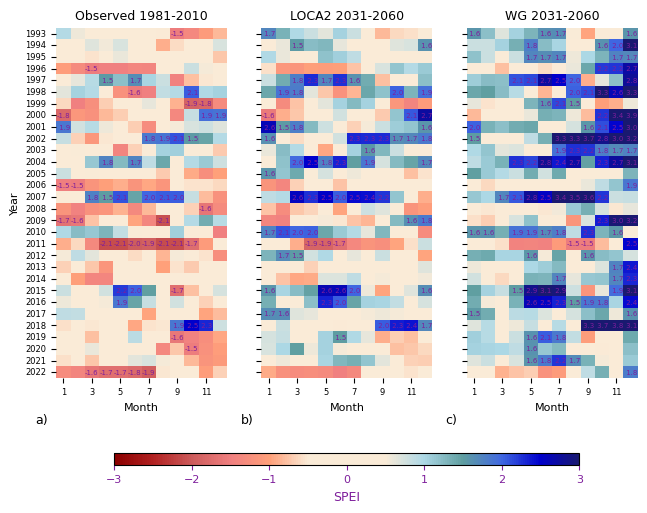

In [53]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.5, 6.5)
axs = Fig1.subplots(nrows=1, ncols=3, sharey=True)
#ax11 = Fig1.add_subplot(1,3,1)
axs[0] = sns.heatmap( pvbT3MoObs, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                    annot=AnnotMat_Obs1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                    annot_kws={'fontsize':5, 'color':'xkcd:purple'}, ax=axs[0] )
#                    cbar_kws={'label': 'SPEI (1981-2010)',}, ax=ax11 )
cbar11 = axs[0].collections[0].colorbar
cbar11.ax.tick_params(labelsize=6)
cbar11.remove()
axs[0].set_title( "Observed 1981-2010", fontsize=9 )
axs[0].set_xlabel('Month', fontsize=8 )
axs[0].set_ylabel('Year', fontsize=8)
axs[0].tick_params(axis='both', which='major', labelsize=6)
#ax21 = Fig1.add_subplot(1,3,2)
axs[1] = sns.heatmap( pvbT3MoL2Fut, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                    annot=AnnotMat_L2Fut1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                    annot_kws={'fontsize':5, 'color':'xkcd:purple'}, ax=axs[1] )
#                    cbar_kws={'label': 'LOCA2 SPEI (2031-2060)',}, ax=ax21 )
cbar21 = axs[1].collections[0].colorbar
cbar21.ax.tick_params(labelsize=6)
cbar21.remove()
axs[1].set_title( "LOCA2 2031-2060", fontsize=9 )
axs[1].set_xlabel('Month', fontsize=8 )
#ax21.set_ylabel('Year', fontsize=10)
axs[1].set_ylabel( '', fontsize=8 )
axs[1].tick_params(axis='x', which='major', labelsize=6)
axs[1].tick_params(axis='y', which='both', labelleft=False, labelright=False )
#ax31 = Fig1.add_subplot(1,3,3)
axs[2] = sns.heatmap( pvbT3MoFut, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                    annot=AnnotMat_Fut1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                    annot_kws={'fontsize':5, 'color':'xkcd:purple'}, cbar_kws={'label': 'SPEI', }, ax=axs[2] )
#                    cbar_kws={'label': 'WG SPEI (2031-2060)',}, ax=ax31 )
cbar31 = axs[2].collections[0].colorbar
cbar31.ax.tick_params(labelsize=6)
cbar31.remove()
axs[2].set_title( "WG 2031-2060", fontsize=9 )
axs[2].set_xlabel('Month', fontsize=8 )
#ax31.set_ylabel('Year', fontsize=10)
axs[2].set_ylabel('', fontsize=8)
axs[2].tick_params(axis='x', which='major', labelsize=6)
axs[2].tick_params(axis='y', which='both', labelleft=False, labelright=False )
# add the colorbar
cbFig = Fig1.colorbar( axs[2].collections[0], ax=axs[:], shrink=0.8, location='bottom', aspect=40 )
cbFig.set_label("SPEI", fontsize=9, color='xkcd:purple')
cbFig.ax.tick_params(labelsize=8, colors='xkcd:purple')
# add subplot ids
trans11 = mtransforms.ScaledTranslation(-15/72, -(3.8*75)/72, Fig1.dpi_scale_trans)
txt11 = axs[0].text(0.0, 1.0, "a)", transform=axs[0].transAxes+trans11, fontsize=9 )
trans22 = mtransforms.ScaledTranslation(-15/72, -(3.8*75)/72, Fig1.dpi_scale_trans)
txt22 = axs[1].text(0.0, 1.0, "b)", transform=axs[1].transAxes+trans22, fontsize=9 )
trans33 = mtransforms.ScaledTranslation(-15/72, -(3.8*75)/72, Fig1.dpi_scale_trans)
txt33 = axs[2].text(0.0, 1.0, "c)", transform=axs[2].transAxes+trans33, fontsize=9 )
Fig1.savefig( OutFileSVG, dpi=600 )
Fig1.savefig( OutFilePNG, dpi=600 )
Fig1.savefig( OutFilePDF, dpi=600 )

#### SPI

In [54]:
bT3MoFut = spi3DF[["WG SPI (2031-2060)"]].copy()
bT3MoL2Fut = spi3DF[["LOCA2 SPI (2031-2060)"]].copy()
bT3MoObs = spi3DF[["SPI (1981-2010)"]].copy()

In [55]:
bT3MoFut["Month"] = bT3MoFut.index.month
bT3MoFut["Year"] = bT3MoFut.index.year

In [56]:
bT3MoL2Fut["Month"] = bT3MoL2Fut.index.month
bT3MoL2Fut["Year"] = bT3MoL2Fut.index.year

In [57]:
bT3MoObs["Month"] = bT3MoObs.index.month
bT3MoObs["Year"] = bT3MoObs.index.year

In [58]:
pvbT3MoFut = bT3MoFut.pivot( index="Year", columns="Month", values="WG SPI (2031-2060)" )
pvbT3MoL2Fut = bT3MoL2Fut.pivot( index="Year", columns="Month", values="LOCA2 SPI (2031-2060)" )
pvbT3MoObs = bT3MoObs.pivot( index="Year", columns="Month", values="SPI (1981-2010)" )

In [59]:
# get the annotation stuff
NumYrs = len( pvbT3MoObs )
allSPEI_1 = pvbT3MoObs.to_numpy( dtype=np.float32 )
matLister1 = list()
for iI in range( NumYrs ):
    rowLister = list()
    for jJ in range(12):
        cVal = allSPEI_1[iI, jJ]
        if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
            rowLister.append( "%4.1f" % cVal )
        else:
            rowLister.append( "" )
        # end if
    # end inner for
    matLister1.append( rowLister )
# end outer for
AnnotMat_Obs1 = np.array( matLister1 )

In [60]:
# get the annotation stuff
NumYrs = len( pvbT3MoFut )
allSPEI_1 = pvbT3MoFut.to_numpy( dtype=np.float32 )
matLister1 = list()
for iI in range( NumYrs ):
    rowLister = list()
    for jJ in range(12):
        cVal = allSPEI_1[iI, jJ]
        if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
            rowLister.append( "%4.1f" % cVal )
        else:
            rowLister.append( "" )
        # end if
    # end inner for
    matLister1.append( rowLister )
# end outer for
AnnotMat_Fut1 = np.array( matLister1 )

In [61]:
# get the annotation stuff
NumYrs = len( pvbT3MoL2Fut )
allSPEI_1 = pvbT3MoL2Fut.to_numpy( dtype=np.float32 )
matLister1 = list()
for iI in range( NumYrs ):
    rowLister = list()
    for jJ in range(12):
        cVal = allSPEI_1[iI, jJ]
        if ( cVal >= 1.5 ) or ( cVal <= -1.5 ):
            rowLister.append( "%4.1f" % cVal )
        else:
            rowLister.append( "" )
        # end if
    # end inner for
    matLister1.append( rowLister )
# end outer for
AnnotMat_L2Fut1 = np.array( matLister1 )

In [62]:
OutFilePDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "Compare_SPI_3mon_%s.pdf" % BasKey ) )
OutFileSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "Compare_SPI_3mon_%s.svg" % BasKey ) )
OutFilePNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "Compare_SPI_3mon_%s.png" % BasKey ) )

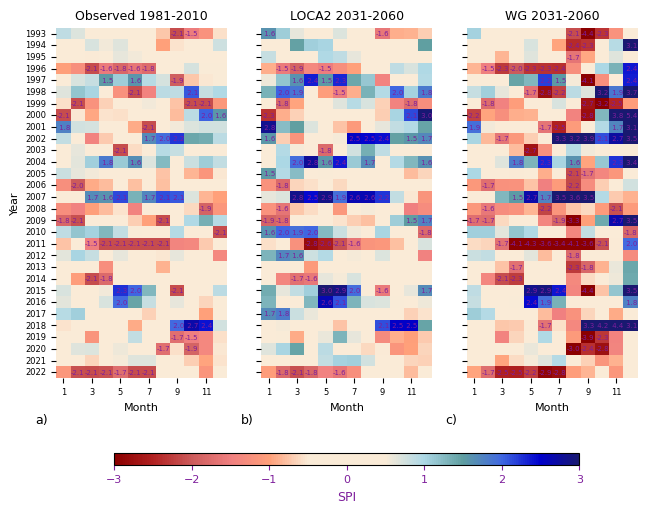

In [63]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.5, 6.5)
axs = Fig1.subplots(nrows=1, ncols=3, sharey=True)
axs[0] = sns.heatmap( pvbT3MoObs, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                    annot=AnnotMat_Obs1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                    annot_kws={'fontsize':5, 'color':'xkcd:purple'}, ax=axs[0] )
cbar11 = axs[0].collections[0].colorbar
cbar11.ax.tick_params(labelsize=6)
cbar11.remove()
axs[0].set_title( "Observed 1981-2010", fontsize=9 )
axs[0].set_xlabel('Month', fontsize=8 )
axs[0].set_ylabel('Year', fontsize=8)
axs[0].tick_params(axis='both', which='major', labelsize=6)
axs[1] = sns.heatmap( pvbT3MoL2Fut, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                    annot=AnnotMat_L2Fut1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                    annot_kws={'fontsize':5, 'color':'xkcd:purple'}, ax = axs[1] )
cbar21 = axs[1].collections[0].colorbar
cbar21.ax.tick_params(labelsize=6)
cbar21.remove()
axs[1].set_title( "LOCA2 2031-2060", fontsize=9 )
axs[1].set_xlabel('Month', fontsize=8 )
axs[1].set_ylabel( '', fontsize=8 )
axs[1].tick_params(axis='x', which='major', labelsize=6)
axs[1].tick_params(axis='y', which='both', labelleft=False, labelright=False )
axs[2] = sns.heatmap( pvbT3MoFut, vmin=pMin, vmax=pMax, cmap=SegCMap, center=0.0,
                    annot=AnnotMat_Fut1, fmt="s", linecolor="gainsboro", linewidths=0.0,
                    annot_kws={'fontsize':5, 'color':'xkcd:purple'}, ax=axs[2] )
cbar31 = axs[2].collections[0].colorbar
cbar31.ax.tick_params(labelsize=6)
cbar31.remove()
axs[2].set_title( "WG 2031-2060", fontsize=9 )
axs[2].set_xlabel('Month', fontsize=8 )
axs[2].set_ylabel( '', fontsize=8 )
axs[2].tick_params(axis='x', which='major', labelsize=6)
axs[2].tick_params(axis='y', which='both', labelleft=False, labelright=False )
# add the colorbar
cbFig = Fig1.colorbar( axs[2].collections[0], ax=axs[:], shrink=0.8, location='bottom', aspect=40 )
cbFig.set_label("SPI", fontsize=9, color='xkcd:purple')
cbFig.ax.tick_params(labelsize=8, colors='xkcd:purple')
# add subplot ids
trans11 = mtransforms.ScaledTranslation(-15/72, -(3.8*75)/72, Fig1.dpi_scale_trans)
txt11 = axs[0].text(0.0, 1.0, "a)", transform=axs[0].transAxes+trans11, fontsize=9 )
trans22 = mtransforms.ScaledTranslation(-15/72, -(3.8*75)/72, Fig1.dpi_scale_trans)
txt22 = axs[1].text(0.0, 1.0, "b)", transform=axs[1].transAxes+trans22, fontsize=9 )
trans33 = mtransforms.ScaledTranslation(-15/72, -(3.8*75)/72, Fig1.dpi_scale_trans)
txt33 = axs[2].text(0.0, 1.0, "c)", transform=axs[2].transAxes+trans33, fontsize=9 )
# save
Fig1.savefig( OutFileSVG, dpi=600 )
Fig1.savefig( OutFilePNG, dpi=600 )
Fig1.savefig( OutFilePDF, dpi=600 )